# Evaluation Code for KSQL and ML
Before evaluating, please run KSQL infrastructure with `test.pcap` generated from `../datasets/preparation2.py`, then run `../rule-detection/evaluation/consumer/script.py` to consume the results from Kafka, and lastly run `../rule-detection/evaluation/ksql_evaluation_dos.py` and `../rule-detection/evaluation/ksql_evaluation_ps.py` to find list of packets in the pcap (in the form of index) that is malicious/detected.

**Metrics**
- Accuracy, Precision, Recall, F1-Score
- Inference Time for ML

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = "1"

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

In [28]:
DOS_MODEL_LOCATION = "../ai-detection/notebooks/modelsdossinglethread/postfs"
PS_MODEL_LOCATION = "../ai-detection/notebooks/modelspssinglethread/postfs"

## Post-Processing for KSQL Predictions

In [5]:
# Get PCAP Indexes of all flows
# For example, if 125th, 126th, and 127th is part of k-th flow (in whole dataset train & test), then flow_packets[k] = [125, 126, 127]
flow_packets = []
with open("../datasets/output-old/pcap_indexes_run_index.txt") as file:
    for line in file:
        indexes = line.strip().split(",")
        if len(indexes[-1]) == 0:
            indexes = indexes[:-1]
        indexes = [int(x) for x in indexes]
        flow_packets.append(indexes)

In [6]:
# Creating mapping to convert whole dataset PCAP indexes to test dataset PCAP indexes
full_to_test_mapping = {}
with open("../datasets/output-old/test_pcap_index_mapping.txt") as file:
    for line in file:
        before, after = line.strip().split(",")
        before = int(before)
        after = int(after)
        assert before not in full_to_test_mapping
        full_to_test_mapping[before] = after

In [7]:
# Convert using mapping
test_flow_packets = []
for cur_packets in flow_packets:
    new_packets = []
    is_in_test = True

    debug_partial = False
    for idx in cur_packets:
        if idx not in full_to_test_mapping:
            is_in_test = False
            assert not debug_partial # if assertion error, there may be problem in your dataset preparation
            break
        debug_partial = True
        new_packets.append(full_to_test_mapping[idx])
    if is_in_test:
        test_flow_packets.append(new_packets)
    else:
        test_flow_packets.append(None)

In [8]:
test_flow_packets_set = [set(i) if i is not None else None for i in test_flow_packets]

In [9]:
np_test_flow_packets_set = pd.Series(np.array(test_flow_packets_set))
flow_packets_set_test_only = np_test_flow_packets_set[~np_test_flow_packets_set.isna()]

In [10]:
with open("../rule-detection/evaluation/detected_ksql_2_slowloris.txt") as file:
    detected_dos_idxs = [int(x.strip()) for x in file.readlines()]
detected_dos_idx_set = set(detected_dos_idxs)

with open("../rule-detection/evaluation/detected_ksql_2_portscan.txt") as file:
    detected_portscan_idxs = [int(x.strip()) for x in file.readlines()]
detected_portscan_idx_set = set(detected_portscan_idxs)

In [11]:
is_detected_dos = np.array([len(detected_dos_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_dos = pd.Series(is_detected_dos)

is_detected_portscan = np.array([len(detected_portscan_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_portscan = pd.Series(is_detected_portscan)

In [12]:
is_detected_dos.index = flow_packets_set_test_only.index
is_detected_portscan.index = flow_packets_set_test_only.index

In [13]:
# Load Test Dataset
flink_test = pd.read_csv('../datasets/output/test_final.csv', parse_dates=['Timestamp'], index_col=0)

In [14]:
assert set(flink_test['Old Index'].values).issubset(set(is_detected_dos.index))
assert set(flink_test['Old Index'].values).issubset(set(is_detected_portscan.index))

In [15]:
is_detected_dos_df = pd.DataFrame(is_detected_dos, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_dos_df['Binary Prediction'] = np.where(is_detected_dos_df['Binary Prediction'], 'Slowloris', 'Not Slowloris')

is_detected_ps_df = pd.DataFrame(is_detected_portscan, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_ps_df['Binary Prediction'] = np.where(is_detected_ps_df['Binary Prediction'], 'Portscan', 'Not Portscan')

In [16]:
flink_test_binary_dos = flink_test.merge(is_detected_dos_df, on=['Old Index'], how='left', indicator=True)
flink_test_binary_ps = flink_test.merge(is_detected_ps_df, on=['Old Index'], how='left', indicator=True)

In [15]:
flink_test_binary_dos["_merge"].value_counts()

_merge
both          153696
left_only          0
right_only         0
Name: count, dtype: int64

In [16]:
flink_test_binary_ps["_merge"].value_counts()

_merge
both          153696
left_only          0
right_only         0
Name: count, dtype: int64

In [17]:
flink_test_binary_dos['Binary Label'] = np.where(flink_test_binary_dos['Label'] == 'Slowloris', 'Slowloris', 'Not Slowloris')
flink_test_binary_ps['Binary Label'] = np.where(flink_test_binary_ps['Label'] == 'Portscan', 'Portscan', 'Not Portscan')

In [18]:
y_true_dos = flink_test_binary_dos['Binary Label']
y_pred_ksql_dos = flink_test_binary_dos['Binary Prediction']

y_true_ps = flink_test_binary_ps['Binary Label']
y_pred_ksql_ps = flink_test_binary_ps['Binary Prediction']

## Accuracy, Precision, Recall, F1-Score

### DoS

In [19]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{DOS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{DOS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{DOS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Fwd Seg Size Min', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Bwd RST Flags', 'Bwd Packet Length Max', 'FIN Flag Count', 'Fwd IAT Min', 'Protocol', 'Bwd Segment Size Avg', 'Flow IAT Mean', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow IAT Min', 'RST Flag Count', 'Flow Duration', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Active Min', 'Bwd IAT Min', 'Bwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd IAT Max', 'SYN Flag Count', 'Idle Max', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Fwd IAT Mean', 'Fwd Packets/s', 'Average Packet Size', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd Packets/s', 'Bwd IAT Total', 'Packet Length Mean', 'Packet Length Max', 'Bwd PSH Flags', 'Flow IAT Std', 'Packet Length Std', 'Fwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd IAT Std', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Fwd Bytes/Bulk Avg', 'ACK Flag Count', 'Packet Length Variance']

top_3_models = ['xg', 'et', 'lgbm']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

#### KSQL

In [20]:
y_pred_ksql_dos = labelencoder.transform(y_pred_ksql_dos)
y_true_dos = labelencoder.transform(y_true_dos)

Accuracy of KSQL: 0.7858369768894441
Precision of KSQL: 0.0
Recall of KSQL: 0.0
F1-score of KSQL: 0.0
              precision    recall  f1-score   support

           0    0.99067   0.79170   0.88008    152558
           1    0.00000   0.00000   0.00000      1138

    accuracy                        0.78584    153696
   macro avg    0.49533   0.39585   0.44004    153696
weighted avg    0.98333   0.78584   0.87356    153696



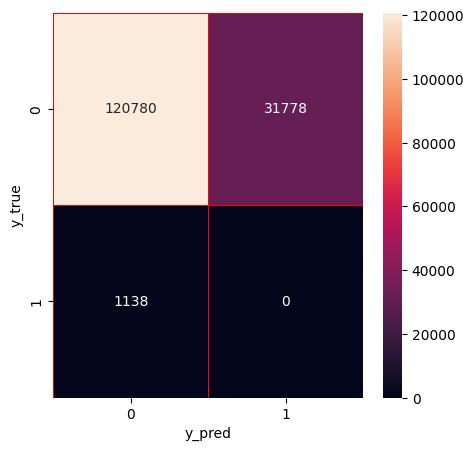

In [21]:
# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_pred_ksql_dos, average='binary')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_dos, y_pred_ksql_dos)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_dos, y_pred_ksql_dos, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_pred_ksql_dos)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Machine Learning

Prediction time per sample:  0.00011297177454344609
Accuracy of DT: 0.9998828856964397
Precision of DT: 0.9886561954624782
Recall of DT: 0.9956063268892794
F1-score of DT: 0.9921190893169878
              precision    recall  f1-score   support

           0    0.99997   0.99991   0.99994    152558
           1    0.98866   0.99561   0.99212      1138

    accuracy                        0.99988    153696
   macro avg    0.99431   0.99776   0.99603    153696
weighted avg    0.99988   0.99988   0.99988    153696



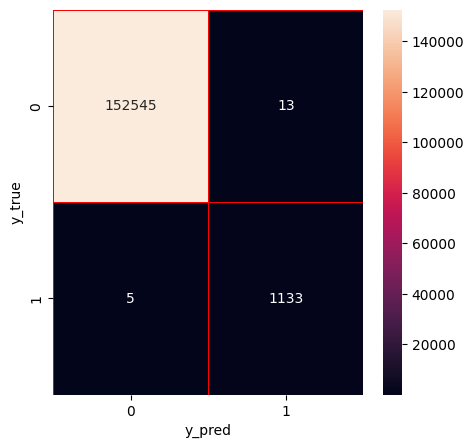

In [22]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.001690788502845073
Accuracy of RF: 0.9976642202789923
Precision of RF: 0.998719590268886
Recall of RF: 0.6854130052724078
F1-score of RF: 0.8129233976029182
              precision    recall  f1-score   support

           0    0.99766   0.99999   0.99882    152558
           1    0.99872   0.68541   0.81292      1138

    accuracy                        0.99766    153696
   macro avg    0.99819   0.84270   0.90587    153696
weighted avg    0.99767   0.99766   0.99745    153696



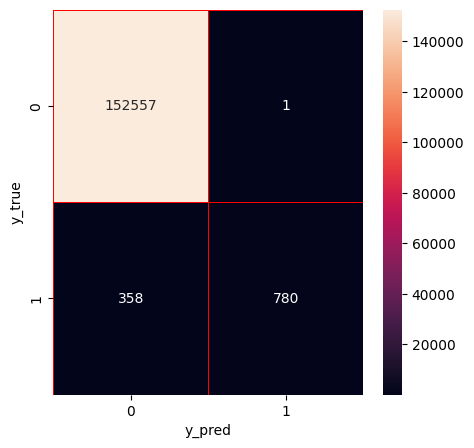

In [23]:
# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0018114016598620665
Accuracy of ET: 0.9976902456797835
Precision of ET: 0.9987261146496815
Recall of ET: 0.6889279437609842
F1-score of ET: 0.8153926157046282
              precision    recall  f1-score   support

           0    0.99768   0.99999   0.99884    152558
           1    0.99873   0.68893   0.81539      1138

    accuracy                        0.99769    153696
   macro avg    0.99821   0.84446   0.90712    153696
weighted avg    0.99769   0.99769   0.99748    153696



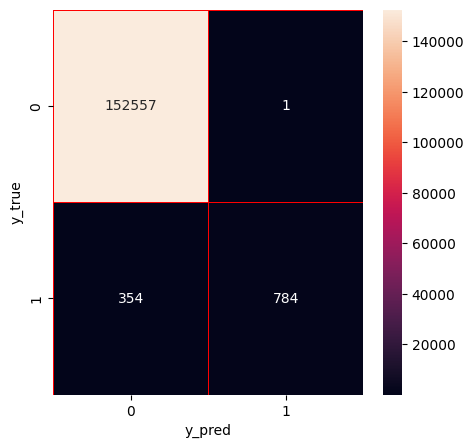

In [24]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00039959497410085035
Accuracy of XG: 0.9980415885904643
Precision of XG: 0.99880810488677
Recall of XG: 0.7363796133567663
F1-score of XG: 0.847749114820435
              precision    recall  f1-score   support

           0    0.99804   0.99999   0.99901    152558
           1    0.99881   0.73638   0.84775      1138

    accuracy                        0.99804    153696
   macro avg    0.99842   0.86819   0.92338    153696
weighted avg    0.99804   0.99804   0.99789    153696



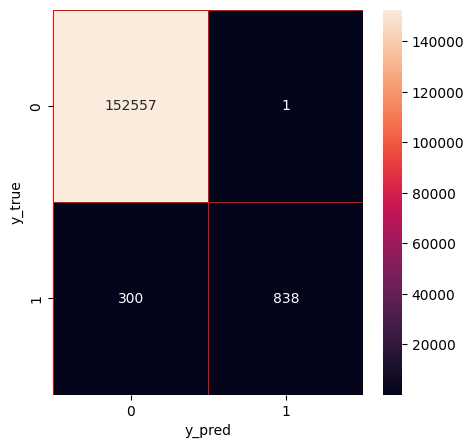

In [40]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0006034939258812915
Accuracy of LGBM: 0.9976902456797835
Precision of LGBM: 0.9949431099873578
Recall of LGBM: 0.6915641476274165
F1-score of LGBM: 0.815966822187662
              precision    recall  f1-score   support

           0    0.99770   0.99997   0.99884    152558
           1    0.99494   0.69156   0.81597      1138

    accuracy                        0.99769    153696
   macro avg    0.99632   0.84577   0.90740    153696
weighted avg    0.99768   0.99769   0.99748    153696



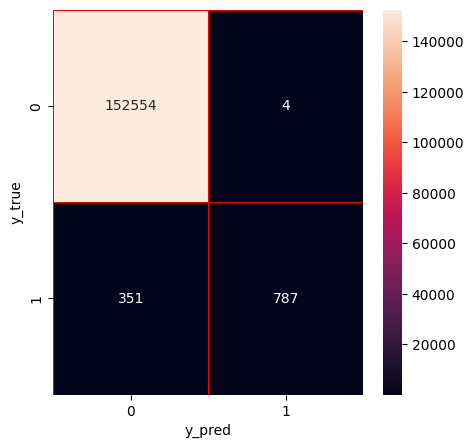

In [41]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00021652910527204092
Accuracy of Cat: 0.9976967520299813
Precision of Cat: 0.9987277353689568
Recall of Cat: 0.6898066783831283
F1-score of Cat: 0.816008316008316
              precision    recall  f1-score   support

           0    0.99769   0.99999   0.99884    152558
           1    0.99873   0.68981   0.81601      1138

    accuracy                        0.99770    153696
   macro avg    0.99821   0.84490   0.90742    153696
weighted avg    0.99770   0.99770   0.99749    153696



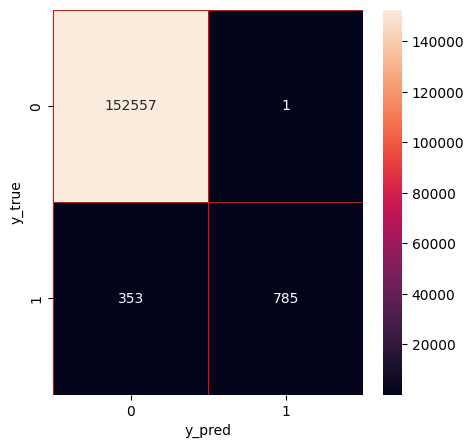

In [43]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [44]:
top_3_models

['xg', 'et', 'lgbm']

Prediction time per sample:  0.007200372633575624
Accuracy of OCSE: 0.9976902456797835
Precision of OCSE: 0.9949431099873578
Recall of OCSE: 0.6915641476274165
F1-score of OCSE: 0.815966822187662
              precision    recall  f1-score   support

           0    0.99770   0.99997   0.99884    152558
           1    0.99494   0.69156   0.81597      1138

    accuracy                        0.99769    153696
   macro avg    0.99632   0.84577   0.90740    153696
weighted avg    0.99768   0.99769   0.99748    153696



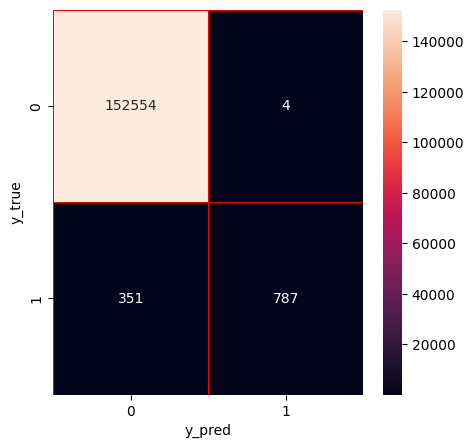

In [45]:
# OCSE

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

model_1_test = xg.predict(X_test_fs).reshape(-1, 1)
model_2_test = et.predict(X_test_fs).reshape(-1, 1)
model_3_test = lgbm.predict(X_test_fs).reshape(-1, 1)

model_1_prob_test = xg.predict_proba(X_test_fs)
model_2_prob_test = et.predict_proba(X_test_fs)
model_3_prob_test = lgbm.predict_proba(X_test_fs)

x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='binary')

# Print results
print('Accuracy of OCSE: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of OCSE: ' + str(precision))
print('Recall of OCSE: ' + str(recall))
print('F1-score of OCSE: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Port Scan

In [25]:
dt = joblib.load(f"{PS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{PS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{PS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{PS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{PS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{PS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{PS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{PS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{PS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Flow Duration', 'Bwd RST Flags', 'RST Flag Count', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Flow IAT Max', 'Fwd Packet Length Max', 'Packet Length Max', 'Bwd Packet Length Max', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Act Data Pkts', 'Total Length of Fwd Packet', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std']

top_3_models = ['et', 'lgbm', 'rf']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_ps['Binary Label'])

#### KSQL

In [27]:
y_pred_ksql_ps = labelencoder.transform(y_pred_ksql_ps)
y_true_ps = labelencoder.transform(y_true_ps)

Accuracy of KSQL: 0.9881389235894232
Precision of KSQL: 0.9458736059479554
Recall of KSQL: 0.9999056841046278
F1-score of KSQL: 0.9721394403435575
              precision    recall  f1-score   support

           0    0.99998   0.98507   0.99247    121888
           1    0.94587   0.99991   0.97214     31808

    accuracy                        0.98814    153696
   macro avg    0.97292   0.99249   0.98230    153696
weighted avg    0.98878   0.98814   0.98826    153696



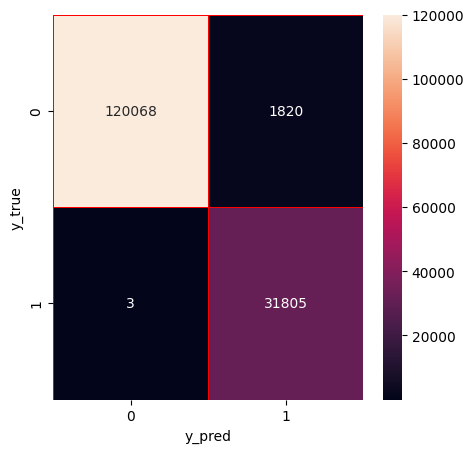

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_pred_ksql_ps, average='binary')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_ps, y_pred_ksql_ps)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_ps, y_pred_ksql_ps, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_pred_ksql_ps)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Machine Learning

Prediction time per sample:  5.720643582206058e-05
Accuracy of DT: 0.9990045284197376
Precision of DT: 0.9977983959742098
Recall of DT: 0.9973905935613682
F1-score of DT: 0.9975944530918353
              precision    recall  f1-score   support

           0    0.99932   0.99943   0.99937    121888
           1    0.99780   0.99739   0.99759     31808

    accuracy                        0.99900    153696
   macro avg    0.99856   0.99841   0.99848    153696
weighted avg    0.99900   0.99900   0.99900    153696



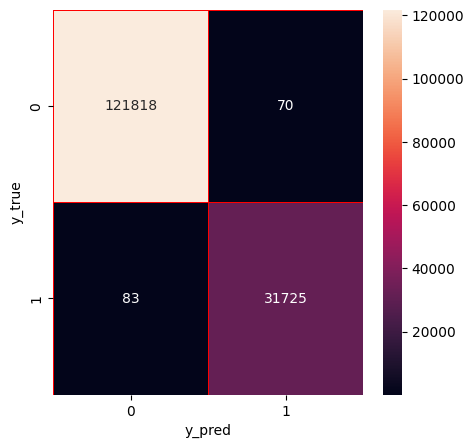

In [29]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0010647427258877711
Accuracy of RF: 0.999590099937539
Precision of RF: 1.0
Recall of RF: 0.9980193661971831
F1-score of RF: 0.9990087013988325
              precision    recall  f1-score   support

           0    0.99948   1.00000   0.99974    121888
           1    1.00000   0.99802   0.99901     31808

    accuracy                        0.99959    153696
   macro avg    0.99974   0.99901   0.99938    153696
weighted avg    0.99959   0.99959   0.99959    153696



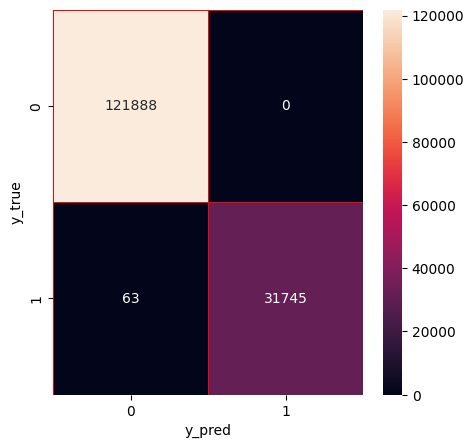

In [30]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.001232797295854113
Accuracy of ET: 0.9991021236727046
Precision of ET: 1.0
Recall of ET: 0.9956614688128773
F1-score of ET: 0.9978260184630896
              precision    recall  f1-score   support

           0    0.99887   1.00000   0.99943    121888
           1    1.00000   0.99566   0.99783     31808

    accuracy                        0.99910    153696
   macro avg    0.99943   0.99783   0.99863    153696
weighted avg    0.99910   0.99910   0.99910    153696



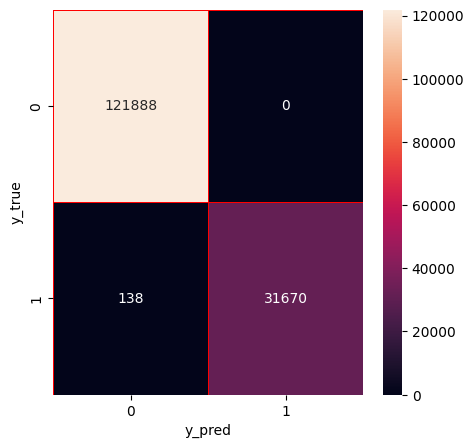

In [31]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00018264238173679192
Accuracy of XG: 0.9995575681865501
Precision of XG: 0.9999684959989918
Recall of XG: 0.9978936116700201
F1-score of XG: 0.9989299763965381
              precision    recall  f1-score   support

           0    0.99945   0.99999   0.99972    121888
           1    0.99997   0.99789   0.99893     31808

    accuracy                        0.99956    153696
   macro avg    0.99971   0.99894   0.99933    153696
weighted avg    0.99956   0.99956   0.99956    153696



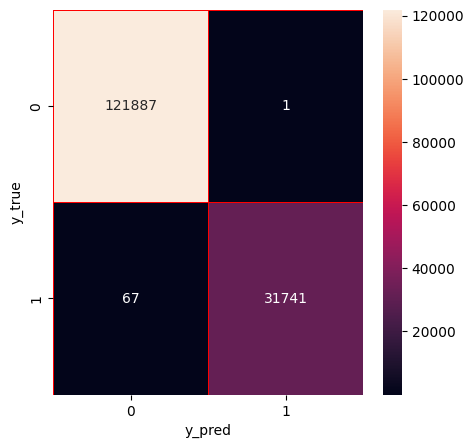

In [33]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0003938817764455369
Accuracy of LGBM: 0.9995966062877368
Precision of LGBM: 1.0
Recall of LGBM: 0.9980508048289738
F1-score of LGBM: 0.9990244516474179
              precision    recall  f1-score   support

           0    0.99949   1.00000   0.99975    121888
           1    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



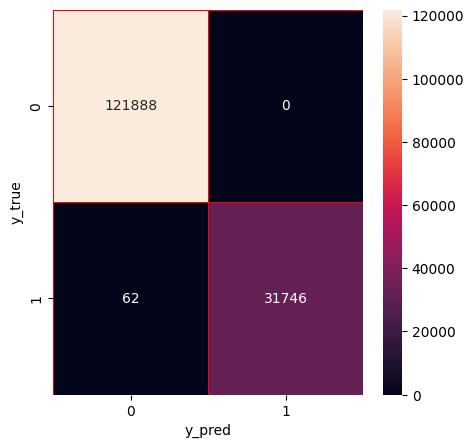

In [34]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00034974449355478664
Accuracy of Cat: 0.9995966062877368
Precision of Cat: 1.0
Recall of Cat: 0.9980508048289738
F1-score of Cat: 0.9990244516474179
              precision    recall  f1-score   support

           0    0.99949   1.00000   0.99975    121888
           1    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



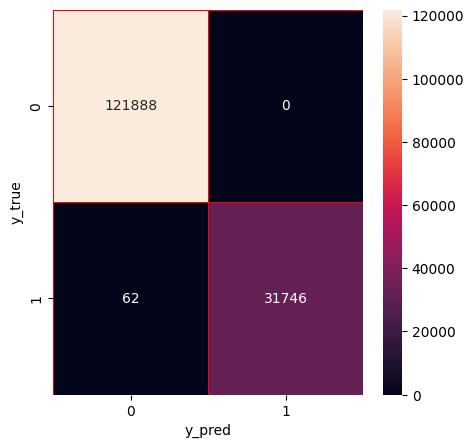

In [35]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [36]:
top_3_models

['et', 'lgbm', 'rf']

Prediction time per sample:  0.005495229004175494
Accuracy of OCSE: 0.999590099937539
Precision of OCSE: 1.0
Recall of OCSE: 0.9980193661971831
F1-score of OCSE: 0.9990087013988325
              precision    recall  f1-score   support

           0    0.99948   1.00000   0.99974    121888
           1    1.00000   0.99802   0.99901     31808

    accuracy                        0.99959    153696
   macro avg    0.99974   0.99901   0.99938    153696
weighted avg    0.99959   0.99959   0.99959    153696



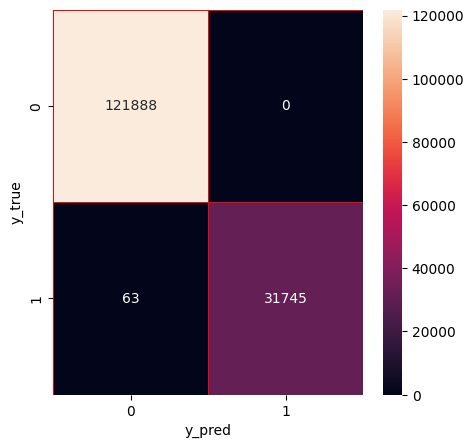

In [37]:
# OCSE

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

model_1_test = et.predict(X_test_fs).reshape(-1, 1)
model_2_test = lgbm.predict(X_test_fs).reshape(-1, 1)
model_3_test = rf.predict(X_test_fs).reshape(-1, 1)

model_1_prob_test = et.predict_proba(X_test_fs)
model_2_prob_test = lgbm.predict_proba(X_test_fs)
model_3_prob_test = rf.predict_proba(X_test_fs)

x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='binary')

# Print results
print('Accuracy of OCSE: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of OCSE: ' + str(precision))
print('Recall of OCSE: ' + str(recall))
print('F1-score of OCSE: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Inference Time

In [24]:
TRIES = 100

In [21]:
# this is in milliseconds, not seconds
def calculate_inference_time_in_ms(foo, tries: int):
    times = []
    for _ in range(tries):
        start = time.time()
        foo()
        end = time.time()
        times.append(((end - start) / len(X_test_fs)) * 1000)
    return np.average(times)

In [22]:
def print_time(name: str, in_ms):
    print(f"Average Inference time for {name}")
    print(in_ms, 'milliseconds')
    print(in_ms / 1000, 'seconds')
    print()

## DoS

In [19]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
stk3 = joblib.load(f"{DOS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Fwd Seg Size Min', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Bwd RST Flags', 'Bwd Packet Length Max', 'FIN Flag Count', 'Fwd IAT Min', 'Protocol', 'Bwd Segment Size Avg', 'Flow IAT Mean', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow IAT Min', 'RST Flag Count', 'Flow Duration', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Active Min', 'Bwd IAT Min', 'Bwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd IAT Max', 'SYN Flag Count', 'Idle Max', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Fwd IAT Mean', 'Fwd Packets/s', 'Average Packet Size', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd Packets/s', 'Bwd IAT Total', 'Packet Length Mean', 'Packet Length Max', 'Bwd PSH Flags', 'Flow IAT Std', 'Packet Length Std', 'Fwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd IAT Std', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Fwd Bytes/Bulk Avg', 'ACK Flag Count', 'Packet Length Variance']

top_3_models = ['xg', 'et', 'lgbm']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

In [25]:
dos_inference_times: list[tuple] = []

# Decision Tree
dos_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))
print(dos_inference_times[0])

# Random Forest
dos_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))
print(dos_inference_times[1])

# Extra Trees
dos_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))
print(dos_inference_times[2])

# XGBoost
dos_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))
print(dos_inference_times[3])

# LightGBM
dos_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))
print(dos_inference_times[4])

# CatBoost
dos_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs, thread_count=1), TRIES)))
print(dos_inference_times[5])

# OCSE (Change based on training's top 3 models results)
def ocse_timer():
    model_1_test = xg.predict(X_test_fs).reshape(-1, 1)
    model_2_test = et.predict(X_test_fs).reshape(-1, 1)
    model_3_test = lgbm.predict(X_test_fs).reshape(-1, 1)

    model_1_prob_test = xg.predict_proba(X_test_fs)
    model_2_prob_test = et.predict_proba(X_test_fs)
    model_3_prob_test = lgbm.predict_proba(X_test_fs)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    stk3.predict(x_test)

dos_inference_times.append(("OCSE", calculate_inference_time_in_ms(ocse_timer, TRIES)))
print(dos_inference_times[6])

('DT', 0.00010034518889181566)
('RF', 0.0016335340407945553)
('ET', 0.001974998601595362)
('XG', 0.0006227018732392189)
('LGBM', 0.0013633909887903165)
('Cat', 0.0006455421609082323)
('OCSE', 0.00764407802318102)


In [26]:
dos_times = sorted(dos_inference_times, key=lambda x: x[1])
dos_times

[('DT', 0.00010034518889181566),
 ('XG', 0.0006227018732392189),
 ('Cat', 0.0006455421609082323),
 ('LGBM', 0.0013633909887903165),
 ('RF', 0.0016335340407945553),
 ('ET', 0.001974998601595362),
 ('OCSE', 0.00764407802318102)]

In [27]:
[[a, format(b, '.5f')] for a, b in dos_times]

[['DT', '0.00010'],
 ['XG', '0.00062'],
 ['Cat', '0.00065'],
 ['LGBM', '0.00136'],
 ['RF', '0.00163'],
 ['ET', '0.00197'],
 ['OCSE', '0.00764']]

## Port Scan

In [29]:
dt = joblib.load(f"{PS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{PS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{PS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{PS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{PS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{PS_MODEL_LOCATION}/cat_tuned.pkl")
stk3 = joblib.load(f"{PS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Flow Duration', 'Bwd RST Flags', 'RST Flag Count', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Flow IAT Max', 'Fwd Packet Length Max', 'Packet Length Max', 'Bwd Packet Length Max', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Act Data Pkts', 'Total Length of Fwd Packet', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std']

top_3_models = ['et', 'lgbm', 'rf']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_ps['Binary Label'])

In [31]:
ps_inference_times: list[tuple] = []

# Decision Tree
ps_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))
print(ps_inference_times[0])

# Random Forest
ps_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))
print(ps_inference_times[1])

# Extra Trees
ps_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))
print(ps_inference_times[2])

# XGBoost
ps_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))
print(ps_inference_times[3])

# LightGBM
ps_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))
print(ps_inference_times[4])

# CatBoost
ps_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs, thread_count=1), TRIES)))
print(ps_inference_times[5])

# OCSE (Change based on training's top 3 models results)
def ocse_timer():
    model_1_test = et.predict(X_test_fs).reshape(-1, 1)
    model_2_test = lgbm.predict(X_test_fs).reshape(-1, 1)
    model_3_test = rf.predict(X_test_fs).reshape(-1, 1)

    model_1_prob_test = et.predict_proba(X_test_fs)
    model_2_prob_test = lgbm.predict_proba(X_test_fs)
    model_3_prob_test = rf.predict_proba(X_test_fs)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    stk3.predict(x_test)

ps_inference_times.append(("OCSE", calculate_inference_time_in_ms(ocse_timer, TRIES)))
print(ps_inference_times[6])

('DT', 4.7295938152684126e-05)
('RF', 0.0009398724067069677)
('ET', 0.0010855340030623702)
('XG', 0.00044439021321899717)
('LGBM', 0.0007316776049675705)
('Cat', 0.001207540758371403)
('OCSE', 0.005689389909055862)


In [33]:
ps_times = sorted(ps_inference_times, key=lambda x: x[1])
ps_times

[('DT', 4.7295938152684126e-05),
 ('XG', 0.00044439021321899717),
 ('LGBM', 0.0007316776049675705),
 ('RF', 0.0009398724067069677),
 ('ET', 0.0010855340030623702),
 ('Cat', 0.001207540758371403),
 ('OCSE', 0.005689389909055862)]

In [34]:
[[a, format(b, '.5f')] for a, b in ps_times]

[['DT', '0.00005'],
 ['XG', '0.00044'],
 ['LGBM', '0.00073'],
 ['RF', '0.00094'],
 ['ET', '0.00109'],
 ['Cat', '0.00121'],
 ['OCSE', '0.00569']]

In [35]:
[[a, format(b, '.5f')] for a, b in dos_times]

[['DT', '0.00010'],
 ['XG', '0.00062'],
 ['Cat', '0.00065'],
 ['LGBM', '0.00136'],
 ['RF', '0.00163'],
 ['ET', '0.00197'],
 ['OCSE', '0.00764']]

## Bad ksqlDB Port Scan Analysis

In [27]:
ksqldb_success = flink_test_binary_ps[(flink_test_binary_ps['Binary Prediction'] == 'Portscan') & (flink_test_binary_ps['Label'] == 'Portscan')]

In [19]:
ksqldb_failed = flink_test_binary_ps[(flink_test_binary_ps['Binary Prediction'] == 'Portscan') & (flink_test_binary_ps['Label'] == 'Benign')]

In [20]:
ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")]

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index,Binary Prediction,_merge,Binary Label
66614,192.168.10.50,42506,192.168.10.3,389,6,2017-07-07 17:55:48.251761,579.0,12,7,172.0,...,0,6,3,9,579,Benign,888568,Portscan,both,Not Portscan
66615,192.168.10.50,58198,192.168.10.3,88,6,2017-07-07 17:55:48.270006,1276.0,10,9,3174.0,...,0,6,4,10,1276,Benign,743697,Portscan,both,Not Portscan
77113,192.168.10.50,19458,192.168.10.3,53,17,2017-07-07 17:55:48.251182,233.0,2,2,80.0,...,0,0,0,0,233,Benign,746040,Portscan,both,Not Portscan
77114,192.168.10.50,11299,192.168.10.3,53,17,2017-07-07 17:55:48.252390,229.0,2,2,138.0,...,0,0,0,0,229,Benign,943180,Portscan,both,Not Portscan
77115,192.168.10.50,54695,192.168.10.3,53,17,2017-07-07 17:55:48.252750,200.0,2,2,76.0,...,0,0,0,0,200,Benign,665346,Portscan,both,Not Portscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151075,192.168.10.14,62615,192.168.10.3,53,17,2017-07-07 19:13:59.632983,204.0,2,2,76.0,...,0,0,0,0,204,Benign,1009948,Portscan,both,Not Portscan
151076,192.168.10.14,63259,192.168.10.3,53,17,2017-07-07 19:13:59.919958,338.0,2,2,60.0,...,0,0,0,0,338,Benign,642528,Portscan,both,Not Portscan
151077,192.168.10.14,53264,192.168.10.3,53,17,2017-07-07 19:13:59.920561,204.0,2,2,60.0,...,0,0,0,0,204,Benign,542723,Portscan,both,Not Portscan
151078,192.168.10.3,62473,192.168.10.1,53,17,2017-07-07 19:13:59.921258,60053.0,1,1,55.0,...,0,0,0,0,60053,Benign,462798,Portscan,both,Not Portscan


In [21]:
ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3")]["Dst Port"].unique()

array([ 53, 137])

In [22]:
dns_dc_idx = ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")].index

In [37]:
failed_dc = set(ksqldb_failed.loc[dns_dc_idx]['Timestamp'].sort_values().dt.floor('s').unique())

In [38]:
success = set(ksqldb_success['Timestamp'].sort_values().dt.floor('s').unique())

In [39]:
failed_non_dc = set(ksqldb_failed[~ksqldb_failed.index.isin(dns_dc_idx)]['Timestamp'].sort_values().dt.floor('s').unique())

In [42]:
flow_start_time_diff = failed_non_dc.difference(success.union(failed_dc))
flow_start_time_diff

{Timestamp('2017-07-07 17:55:58')}

In [43]:
ksqldb_failed

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index,Binary Prediction,_merge,Binary Label
66614,192.168.10.50,42506,192.168.10.3,389,6,2017-07-07 17:55:48.251761,579.0,12,7,172.0,...,0,6,3,9,579,Benign,888568,Portscan,both,Not Portscan
66615,192.168.10.50,58198,192.168.10.3,88,6,2017-07-07 17:55:48.270006,1276.0,10,9,3174.0,...,0,6,4,10,1276,Benign,743697,Portscan,both,Not Portscan
74612,192.168.10.8,8352,192.168.10.50,61904,6,2017-07-07 17:55:58.667877,23925.0,17,10,20514.0,...,0,4,5,9,23925,Benign,897704,Portscan,both,Not Portscan
74613,192.168.10.8,8351,192.168.10.50,21,6,2017-07-07 17:55:58.539781,152430.0,22,27,176.0,...,0,12,13,25,152430,Benign,989479,Portscan,both,Not Portscan
77015,192.168.10.50,6106,172.16.0.1,53126,6,2017-07-07 17:55:45.864352,1.0,1,1,0.0,...,0,0,0,0,1,Benign,669203,Portscan,both,Not Portscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151075,192.168.10.14,62615,192.168.10.3,53,17,2017-07-07 19:13:59.632983,204.0,2,2,76.0,...,0,0,0,0,204,Benign,1009948,Portscan,both,Not Portscan
151076,192.168.10.14,63259,192.168.10.3,53,17,2017-07-07 19:13:59.919958,338.0,2,2,60.0,...,0,0,0,0,338,Benign,642528,Portscan,both,Not Portscan
151077,192.168.10.14,53264,192.168.10.3,53,17,2017-07-07 19:13:59.920561,204.0,2,2,60.0,...,0,0,0,0,204,Benign,542723,Portscan,both,Not Portscan
151078,192.168.10.3,62473,192.168.10.1,53,17,2017-07-07 19:13:59.921258,60053.0,1,1,55.0,...,0,0,0,0,60053,Benign,462798,Portscan,both,Not Portscan


In [56]:
ksqldb_failed[~ksqldb_failed.index.isin(dns_dc_idx)]['Timestamp']

74612     2017-07-07 17:55:58.667877
74613     2017-07-07 17:55:58.539781
77015     2017-07-07 17:55:45.864352
77016     2017-07-07 17:55:45.873339
77017     2017-07-07 17:55:45.880741
                     ...            
117680    2017-07-07 18:23:38.311104
117681    2017-07-07 18:23:38.333707
117682    2017-07-07 18:23:38.356204
117731    2017-07-07 18:23:51.959518
117732    2017-07-07 18:23:51.999930
Name: Timestamp, Length: 137, dtype: object

In [ ]:
dns_dc_idx = ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")].index

# Bad ML Slowloris Analysis

In [19]:
flink_train = pd.read_csv('../datasets/output/train_final.csv', index_col=0)
flink_test = pd.read_csv('../datasets/output/test_final.csv', index_col=0)

In [20]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
ocse = joblib.load(f"{DOS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Fwd Seg Size Min', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Bwd RST Flags', 'Bwd Packet Length Max', 'FIN Flag Count', 'Fwd IAT Min', 'Protocol', 'Bwd Segment Size Avg', 'Flow IAT Mean', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow IAT Min', 'RST Flag Count', 'Flow Duration', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Active Min', 'Bwd IAT Min', 'Bwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd IAT Max', 'SYN Flag Count', 'Idle Max', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Fwd IAT Mean', 'Fwd Packets/s', 'Average Packet Size', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd Packets/s', 'Bwd IAT Total', 'Packet Length Mean', 'Packet Length Max', 'Bwd PSH Flags', 'Flow IAT Std', 'Packet Length Std', 'Fwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd IAT Std', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Fwd Bytes/Bulk Avg', 'ACK Flag Count', 'Packet Length Variance']

top_3_models = ['xg', 'et', 'lgbm']

# OCSE (Change based on training's top 3 models results)
def ocse_pred(model, X):
    model_1_test = xg.predict(X).reshape(-1, 1)
    model_2_test = et.predict(X).reshape(-1, 1)
    model_3_test = lgbm.predict(X).reshape(-1, 1)

    model_1_prob_test = xg.predict_proba(X)
    model_2_prob_test = et.predict_proba(X)
    model_3_prob_test = lgbm.predict_proba(X)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    return model.predict(x_test)

# labelencoder = LabelEncoder()
# labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

# X_test_fs = flink_test[fs]
# y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

In [21]:
y_pred_rf = rf.predict(flink_test[fs])
y_pred_et = et.predict(flink_test[fs])
y_pred_xg = xg.predict(flink_test[fs])
y_pred_lgbm = lgbm.predict(flink_test[fs])
y_pred_cat = cat.predict(flink_test[fs])

In [22]:
flink_test = flink_test.reset_index()
flink_train = flink_train.reset_index()

In [23]:
slowloris_test = flink_test[flink_test['Label'] == 'Slowloris']

In [24]:
majority_not_slowloris = (y_pred_rf + y_pred_et + y_pred_xg + y_pred_lgbm + y_pred_cat) < 3
majority_fail_slowloris = slowloris_test[majority_not_slowloris[slowloris_test.index]]
majority_fail_slowloris

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
2938,e1d75b7d-cba3-479b-af99-c3b5d3f7af43,172.16.0.1,54178,192.168.10.50,80,6,2017-07-05 13:08:15.865704,115877776.0,3,3,...,115873789.0,115873789.0,0,0,0,0,0,244909874,Slowloris,25714
2939,d5f63ee9-5c31-4ac6-b0cb-3b7f5541c6d0,172.16.0.1,54186,192.168.10.50,80,6,2017-07-05 13:08:15.865781,115877702.0,3,3,...,115873704.0,115873704.0,0,0,0,0,0,244909811,Slowloris,25719
2940,fd7a552a-4369-44fe-854b-44d75a388dd0,172.16.0.1,54190,192.168.10.50,80,6,2017-07-05 13:08:15.865809,115877676.0,3,3,...,115873707.0,115873707.0,0,0,0,0,0,244909758,Slowloris,25721
2941,a31d44de-faab-46e9-915c-6b5b540e8134,172.16.0.1,54198,192.168.10.50,80,6,2017-07-05 13:08:15.865865,115877620.0,3,3,...,115873534.0,115873534.0,0,0,0,0,0,244909631,Slowloris,25723
2942,6164b663-a38a-4505-84b5-3eb694f9c3e9,172.16.0.1,54188,192.168.10.50,80,6,2017-07-05 13:08:15.865777,115877708.0,3,3,...,115873719.0,115873719.0,0,0,0,0,0,244909792,Slowloris,25718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,fc7216ae-eb56-49a2-a66d-c21e3ae6013b,172.16.0.1,33362,192.168.10.50,80,6,2017-07-05 13:10:34.560235,5025323.0,8,8,...,5002022.0,5002022.0,0,0,0,0,0,5025323,Slowloris,31329
3956,78821399-f888-4d7e-921c-dbd478633c58,172.16.0.1,33340,192.168.10.50,80,6,2017-07-05 13:10:08.881680,996054.0,2,0,...,0.0,0.0,0,0,1,0,1,996054,Slowloris,31230
3957,cd876ab4-d512-49d9-b2b2-94aa755cdbca,172.16.0.1,33344,192.168.10.50,80,6,2017-07-05 13:10:09.234138,999785.0,2,0,...,0.0,0.0,0,0,1,0,1,999785,Slowloris,31247
3958,409fffe3-3363-46e6-9486-bccaaf705c9e,172.16.0.1,33346,192.168.10.50,80,6,2017-07-05 13:10:10.226326,999651.0,2,0,...,0.0,0.0,0,0,1,0,1,999651,Slowloris,31263


In [25]:
majority_success_slowloris = slowloris_test[~slowloris_test.index.isin(majority_fail_slowloris.index)]
majority_success_slowloris

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
324,2bea26cb-9d11-49aa-bc71-0feeae9c330d,172.16.0.1,60300,192.168.10.50,80,6,2017-07-05 13:05:56.233742,102601946.0,14,3,...,51263712.0,5776652.0,0,0,10,1,11,102601946,Slowloris,28611
338,4e9a605f-bf78-48e0-93e1-9ec398d2851a,172.16.0.1,60306,192.168.10.50,80,6,2017-07-05 13:05:58.020223,102607322.0,14,3,...,51263519.0,5780480.0,0,0,10,1,11,102607322,Slowloris,28614
339,4db75f68-d093-4ba9-bd51-cc91a7193526,172.16.0.1,60308,192.168.10.50,80,6,2017-07-05 13:05:58.021343,102606205.0,14,3,...,51263519.0,5780477.0,0,0,10,1,11,102606205,Slowloris,28615
342,f37135a3-c9f7-4b01-bb5f-41956243d746,172.16.0.1,60314,192.168.10.50,80,6,2017-07-05 13:05:59.092001,102687677.0,14,3,...,51327458.0,5744674.0,0,0,10,1,11,102687677,Slowloris,28617
343,48b937e7-c3e9-460c-be70-a48182ebb4a2,172.16.0.1,60316,192.168.10.50,80,6,2017-07-05 13:05:59.093010,102686671.0,14,3,...,51327460.0,5744639.0,0,0,10,1,11,102686671,Slowloris,28619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949,7a7118f8-79f5-42d7-893d-2fd32e39379f,172.16.0.1,33314,192.168.10.50,80,6,2017-07-05 13:10:04.231299,3002679.0,3,0,...,0.0,0.0,0,0,2,0,2,3002679,Slowloris,30959
3952,35640142-f892-4f25-bc0b-1f67b041d70b,172.16.0.1,33318,192.168.10.50,80,6,2017-07-05 13:10:05.223254,3002718.0,3,0,...,0.0,0.0,0,0,2,0,2,3002718,Slowloris,31009
3953,3fca3a3f-2a0d-41ae-8d15-02b7fd5b73c3,172.16.0.1,33322,192.168.10.50,80,6,2017-07-05 13:10:06.351110,3002623.0,3,0,...,0.0,0.0,0,0,2,0,2,3002623,Slowloris,31097
3954,3c57050d-e253-4466-b4a0-6ce55b9c5764,172.16.0.1,33324,192.168.10.50,80,6,2017-07-05 13:10:06.364338,3001417.0,3,0,...,0.0,0.0,0,0,2,0,2,3001417,Slowloris,31098


In [26]:
slowloris_train = flink_train[flink_train['Label'] == 'Slowloris']

In [30]:
def show_kde_plot(selected_feature):
    _, axes = plt.subplots(1, 3, figsize=(18, 3))

    sns.kdeplot(data=slowloris_train[[selected_feature]], x=selected_feature, fill=True, ax=axes[0])
    axes[0].set_title(f'{selected_feature} on Training ({len(slowloris_train)} data)')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Density')

    sns.kdeplot(data=majority_success_slowloris[[selected_feature]], x=selected_feature, fill=True, ax=axes[1])
    axes[1].set_title(f'{selected_feature} on Success Test ({len(majority_success_slowloris)} data)')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Density')

    sns.kdeplot(data=majority_fail_slowloris[[selected_feature]], x=selected_feature, fill=True, ax=axes[2])
    axes[2].set_title(f'{selected_feature} on Failed Test ({len(majority_fail_slowloris)} data)')
    axes[2].set_xlabel('Value')
    axes[2].set_ylabel('Density')

    plt.show()

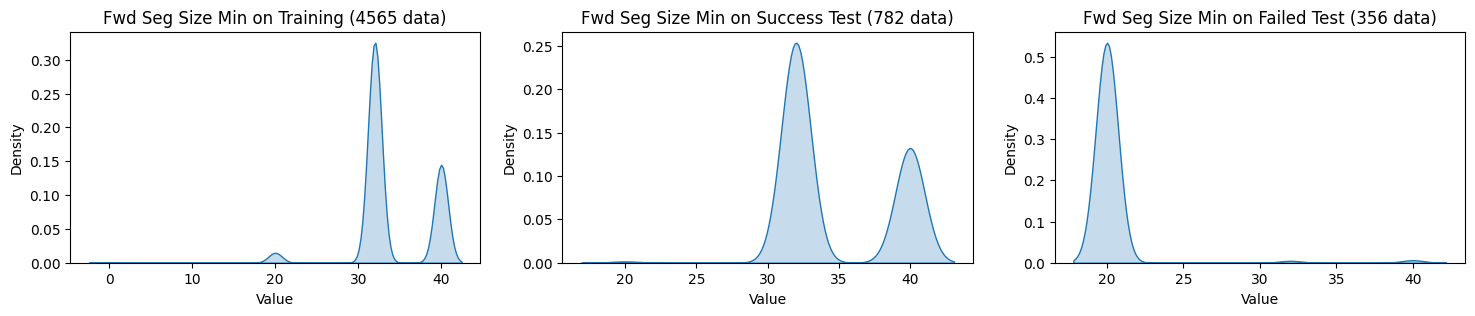

In [31]:
show_kde_plot('Fwd Seg Size Min')

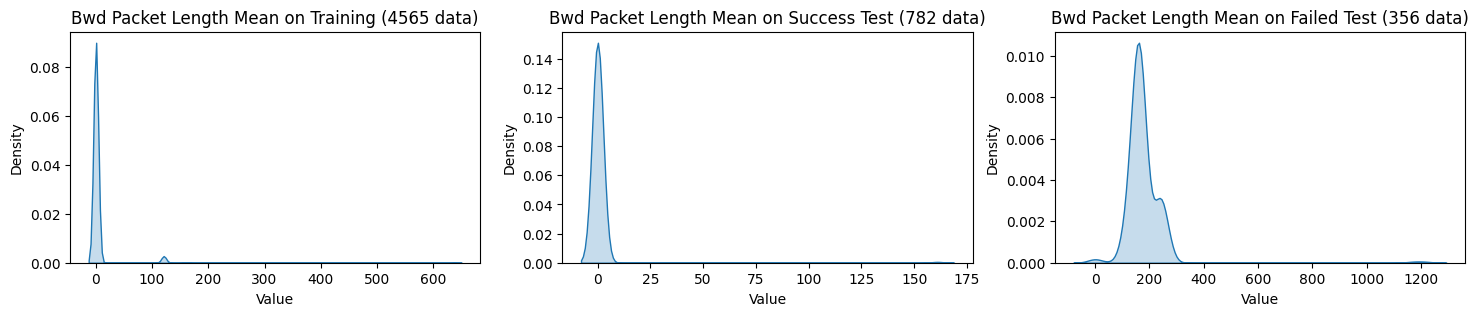

In [32]:
show_kde_plot('Bwd Packet Length Mean')

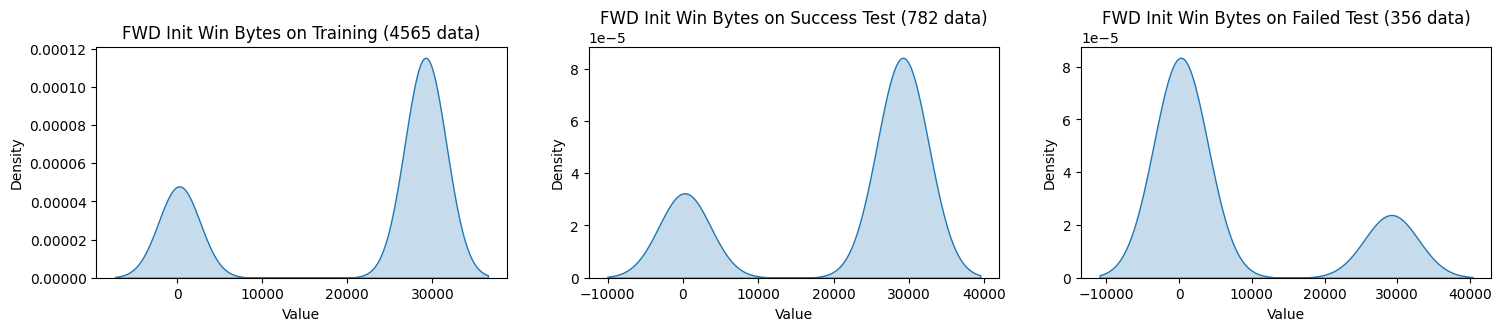

In [33]:
show_kde_plot('FWD Init Win Bytes')